# EOTExplainer: Entropic Optimal Transport

This tutorial covers the `EOTExplainer`, which uses entropic optimal transport for more flexible feature importance computation.

## What You'll Learn

1. When to use EOTExplainer over OTExplainer
2. Adaptive epsilon selection
3. Stochastic transport sampling
4. Handling mixed-type data with Gower distance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from fdfi.explainers import EOTExplainer, OTExplainer

np.random.seed(42)

## Why Entropic OT?

Gaussian OT assumes your data follows a Gaussian distribution. When this assumption is violated (e.g., multimodal data, heavy tails), **Entropic OT** provides a more flexible alternative.

EOTExplainer uses the **Sinkhorn algorithm** to solve:

$$P^* = \arg\min_P \langle C, P \rangle + \epsilon H(P)$$

where $C$ is the cost matrix, $P$ is the transport plan, and $H$ is entropy regularization.

## Example: Non-Gaussian Data

Let's create bimodal data where Gaussian OT may struggle:

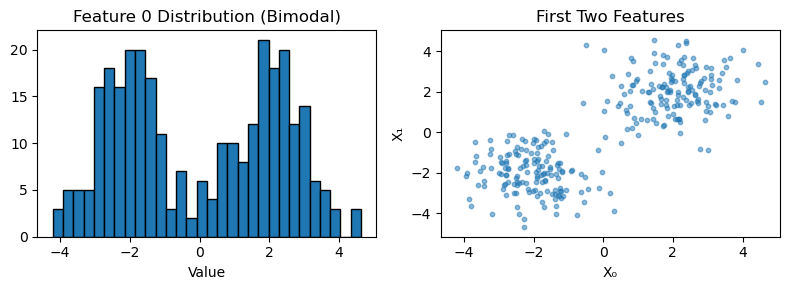

In [2]:
# Create bimodal data
n_samples = 300
n_features = 5

# Mix of two Gaussian clusters
cluster1 = np.random.randn(n_samples // 2, n_features) - 2
cluster2 = np.random.randn(n_samples // 2, n_features) + 2
X_train = np.vstack([cluster1, cluster2])

# Shuffle
np.random.shuffle(X_train)

# Visualize
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.hist(X_train[:, 0], bins=30, edgecolor='black')
plt.title("Feature 0 Distribution (Bimodal)")
plt.xlabel("Value")

plt.subplot(1, 2, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.5, s=10)
plt.xlabel("X₀")
plt.ylabel("X₁")
plt.title("First Two Features")
plt.tight_layout()
plt.show()

In [3]:
# Model: feature 0 is most important
def model(X):
    return X[:, 0] ** 2 + 0.5 * X[:, 1]

X_test = np.vstack([
    np.random.randn(25, n_features) - 2,
    np.random.randn(25, n_features) + 2,
])

## Compare OT vs EOT

In [4]:
# Gaussian OT
ot_explainer = OTExplainer(model, data=X_train, nsamples=50)
ot_results = ot_explainer(X_test)

# Entropic OT with auto epsilon
eot_explainer = EOTExplainer(
    model, 
    data=X_train, 
    nsamples=50,
    auto_epsilon=True,
)
eot_results = eot_explainer(X_test)

# Compare
print("Feature importance comparison:")
print("-" * 40)
print(f"{'Feature':>8} {'OT':>12} {'EOT':>12}")
print("-" * 40)
for i in range(n_features):
    print(f"{i:>8} {ot_results['phi_X'][i]:>12.4f} {eot_results['phi_X'][i]:>12.4f}")

print(f"\nAuto-selected epsilon: {eot_explainer.epsilon:.4f}")

Feature importance comparison:
----------------------------------------
 Feature           OT          EOT
----------------------------------------
       0      79.6976      85.2524
       1      48.0271      52.4058
       2      48.8011      50.7724
       3      46.5330      50.7336
       4      59.7025      59.8619

Auto-selected epsilon: 7.1670


## Epsilon Selection

The `epsilon` parameter controls the entropy regularization:
- **Small epsilon**: Sharp transport (closer to true OT), may be unstable
- **Large epsilon**: Smooth transport, loses structure

Use `auto_epsilon=True` to automatically select based on median pairwise distance.

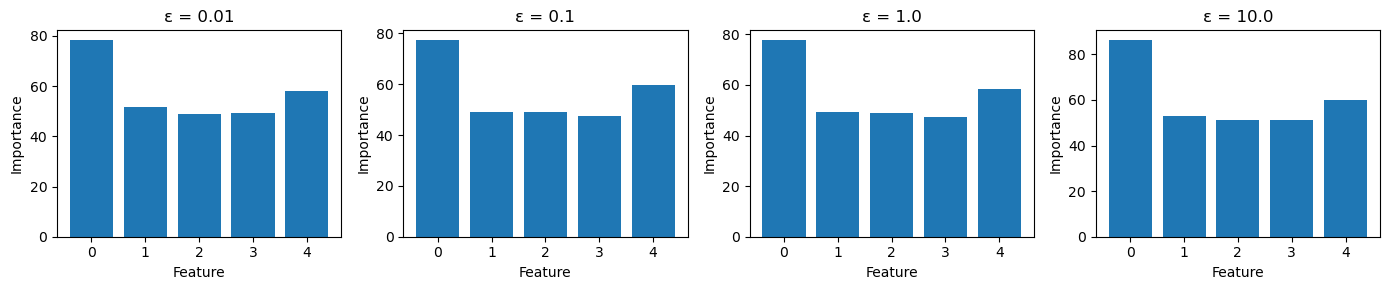

In [5]:
# Compare different epsilon values
epsilon_values = [0.01, 0.1, 1.0, 10.0]
results_by_eps = {}

for eps in epsilon_values:
    explainer = EOTExplainer(
        model, data=X_train, nsamples=50,
        epsilon=eps, auto_epsilon=False
    )
    results_by_eps[eps] = explainer(X_test)

# Plot
fig, axes = plt.subplots(1, len(epsilon_values), figsize=(14, 3))
for ax, eps in zip(axes, epsilon_values):
    phi = results_by_eps[eps]["phi_X"]
    ax.bar(range(n_features), phi)
    ax.set_xlabel("Feature")
    ax.set_ylabel("Importance")
    ax.set_title(f"ε = {eps}")
plt.tight_layout()
plt.show()

## Stochastic Transport Sampling

Instead of using the barycentric map (average transport), you can sample from the transport kernel for variance reduction:

In [6]:
# Without stochastic transport
explainer_det = EOTExplainer(
    model, data=X_train, nsamples=50,
    auto_epsilon=True,
    stochastic_transport=False,
)
results_det = explainer_det(X_test)

# With stochastic transport
explainer_stoch = EOTExplainer(
    model, data=X_train, nsamples=50,
    auto_epsilon=True,
    stochastic_transport=True,
    n_transport_samples=10,
)
results_stoch = explainer_stoch(X_test)

print("Feature importance with stochastic transport:")
print("-" * 50)
print(f"{'Feature':>8} {'Deterministic':>14} {'Stochastic':>14}")
print("-" * 50)
for i in range(n_features):
    print(f"{i:>8} {results_det['phi_X'][i]:>14.4f} {results_stoch['phi_X'][i]:>14.4f}")

Feature importance with stochastic transport:
--------------------------------------------------
 Feature  Deterministic     Stochastic
--------------------------------------------------
       0        85.2524        75.1587
       1        52.4058        48.4361
       2        50.7724        47.8746
       3        50.7336        47.8951
       4        59.8619        59.4248


## Mixed Data Types with Gower Distance

EOTExplainer supports categorical features using Gower distance:

In [7]:
# Create mixed-type data
n_samples = 200

# Continuous features
X_cont = np.random.randn(n_samples, 3)

# Binary feature
X_binary = np.random.choice([0, 1], size=(n_samples, 1))

# Categorical feature (encoded as integers)
X_cat = np.random.choice([0, 1, 2], size=(n_samples, 1))

# Combine
X_mixed = np.hstack([X_cont, X_binary, X_cat])
print(f"Mixed data shape: {X_mixed.shape}")
print(f"Feature types: [continuous, continuous, continuous, binary, categorical]")

Mixed data shape: (200, 5)
Feature types: [continuous, continuous, continuous, binary, categorical]


In [8]:
# Model that uses all features
def mixed_model(X):
    # Continuous contribution
    y = X[:, 0] + 0.5 * X[:, 1]
    # Binary feature effect
    y += 2 * X[:, 3]
    # Categorical feature effect
    y += X[:, 4] * 0.3
    return y

X_test_mixed = np.hstack([
    np.random.randn(30, 3),
    np.random.choice([0, 1], size=(30, 1)),
    np.random.choice([0, 1, 2], size=(30, 1)),
])

In [9]:
# Use Gower distance for mixed types
import numpy as np
feature_types = np.array(["continuous", "continuous", "continuous", "binary", "categorical"])

explainer_gower = EOTExplainer(
    mixed_model,
    data=X_mixed,
    nsamples=50,
    cost_metric="gower",
    feature_types=feature_types,
    auto_epsilon=True,
)

results_mixed = explainer_gower(X_test_mixed)

print("Feature importance for mixed-type data:")
feature_names = ["cont_0", "cont_1", "cont_2", "binary", "categorical"]
for i, name in enumerate(feature_names):
    print(f"  {name}: {results_mixed['phi_X'][i]:.4f}")

print(f"\nDetected types: {explainer_gower.detected_types_['types']}")

Feature importance for mixed-type data:
  cont_0: 0.9021
  cont_1: 0.1426
  cont_2: 0.0004
  binary: 0.2224
  categorical: 0.0882

Detected types: ['continuous' 'continuous' 'continuous' 'binary' 'categorical']


## Target Distribution: Gaussian vs Empirical

EOTExplainer can use either a Gaussian target or an empirical (permuted) target:

In [10]:
# Gaussian target
explainer_gaussian = EOTExplainer(
    model, data=X_train, nsamples=50,
    target="gaussian",
    auto_epsilon=True,
)

# Empirical target
explainer_empirical = EOTExplainer(
    model, data=X_train, nsamples=50,
    target="empirical",
    auto_epsilon=True,
)

results_g = explainer_gaussian(X_test)
results_e = explainer_empirical(X_test)

print("Target distribution comparison:")
print("-" * 45)
print(f"{'Feature':>8} {'Gaussian':>14} {'Empirical':>14}")
print("-" * 45)
for i in range(n_features):
    print(f"{i:>8} {results_g['phi_X'][i]:>14.4f} {results_e['phi_X'][i]:>14.4f}")

Target distribution comparison:
---------------------------------------------
 Feature       Gaussian      Empirical
---------------------------------------------
       0        85.2524        82.9647
       1        52.4058        51.3192
       2        50.7724        50.3143
       3        50.7336        50.0130
       4        59.8619        60.4786


## Best Practices for EOTExplainer

```python
# Recommended settings for most cases
explainer = EOTExplainer(
    model,
    data=X_train,
    nsamples=50,
    auto_epsilon=True,        # Let the algorithm choose
    target="gaussian",        # Standard choice
    stochastic_transport=False,  # Enable for variance reduction
)

# For mixed-type data
explainer = EOTExplainer(
    model,
    data=X_train,
    cost_metric="gower",      # or "auto"
    categorical_threshold=10,  # Unique values ≤ 10 = categorical
)
```

## Summary

Key takeaways:

1. **EOTExplainer** is more flexible than OTExplainer for non-Gaussian data
2. Use `auto_epsilon=True` for automatic regularization tuning
3. Enable `stochastic_transport=True` for variance reduction
4. Use `cost_metric="gower"` for mixed continuous/categorical features
5. Choose `target="empirical"` if you want to stay close to the data distribution